In [1]:
import os
import pickle
import numpy as np
import xml.etree.ElementTree as ET
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.path import Path

In [2]:
def parse_xml_annotations(xml_file):
    """Parses XML annotations to extract tumor regions."""
    if not os.path.exists(xml_file):
        print(f"Warning: Missing annotation file {xml_file}")
        return []
    
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    annotations = []
    for annotation in root.findall(".//Annotation"):
        coords = []
        for coord in annotation.findall(".//Coordinate"):
            x = float(coord.attrib["X"])
            y = float(coord.attrib["Y"])
            coords.append((x, y))
        annotations.append(np.array(coords))
    
    return annotations

In [3]:
def is_point_in_polygon(point, polygon):
    """Check if point is inside polygon using matplotlib Path."""
    path = Path(polygon)
    return path.contains_point(point)

In [4]:
def is_patch_in_tumor_region(x, y, patch_size, annotations):
    """Check if a patch center is inside any tumor region."""
    # If there are no annotations, the slide is all negative
    if not annotations:
        return False
    
    # Use the center of the patch
    center_x = x + patch_size / 2
    center_y = y + patch_size / 2
    
    for polygon in annotations:
        if is_point_in_polygon((center_x, center_y), polygon):
            return True
    return False

In [5]:
def evaluate_patch_predictions(tile_predictions_dict, annotations_dir, patch_size=256, threshold=0.5):
    """
    Evaluate patch predictions against ground truth annotations.
    
    Args:
        tile_predictions_dict: Dictionary with slide names as keys and lists of (x, y, tumor_prob) as values
        annotations_dir: Directory containing XML annotation files
        patch_size: Size of each patch
        threshold: Threshold for classifying as tumor (probability >= threshold is tumor)
        
    Returns:
        Dictionary with evaluation metrics
    """
    y_true = []
    y_pred = []
    
    for slide_name, predictions in tqdm(tile_predictions_dict.items(), desc="Evaluating Slides"):
        # Construct the XML file path - adjust this path format to match your structure
        # Assuming XML files have same name as slide but with .xml extension
        slide_id = os.path.splitext(slide_name)[0]
        xml_file = os.path.join(annotations_dir, f"{slide_id}.xml")
        
        if not os.path.exists(xml_file):
            print(f"Skipping {slide_name} - annotation file not found.")
            continue
        
        annotations = parse_xml_annotations(xml_file)
        
        for x, y, tumor_prob in predictions:
            # Get ground truth
            is_tumor = is_patch_in_tumor_region(x, y, patch_size, annotations)
            # Get prediction
            predicted_tumor = tumor_prob >= threshold
            
            y_true.append(1 if is_tumor else 0)
            y_pred.append(1 if predicted_tumor else 0)
    
    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate metrics
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)  # Same as sensitivity
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # Calculate sensitivity and specificity
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # Create results dictionary
    results = {
        'confusion_matrix': cm,
        'accuracy': accuracy,
        'precision': precision,
        'sensitivity': sensitivity,  # Same as recall
        'specificity': specificity,
        'f1_score': f1,
        'y_true': y_true,
        'y_pred': y_pred
    }
    
    return results


In [6]:
def plot_confusion_matrix(cm, classes=['Normal', 'Tumor'], title='Confusion Matrix'):
    """Plot confusion matrix."""
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    return plt

Evaluating Slides:   2%|▏         | 2/129 [00:09<10:05,  4.77s/it]

Skipping test_003.tif - annotation file not found.


Evaluating Slides:   3%|▎         | 4/129 [00:09<03:53,  1.87s/it]

Skipping test_005.tif - annotation file not found.
Skipping test_006.tif - annotation file not found.
Skipping test_007.tif - annotation file not found.


Evaluating Slides:   6%|▌         | 8/129 [00:10<01:34,  1.28it/s]

Skipping test_009.tif - annotation file not found.


Evaluating Slides:   9%|▊         | 11/129 [00:11<01:11,  1.65it/s]

Skipping test_012.tif - annotation file not found.
Skipping test_014.tif - annotation file not found.
Skipping test_015.tif - annotation file not found.


Evaluating Slides:  12%|█▏        | 16/129 [00:23<03:08,  1.66s/it]

Skipping test_017.tif - annotation file not found.
Skipping test_018.tif - annotation file not found.
Skipping test_019.tif - annotation file not found.
Skipping test_020.tif - annotation file not found.


Evaluating Slides:  16%|█▋        | 21/129 [01:11<09:26,  5.25s/it]

Skipping test_022.tif - annotation file not found.
Skipping test_023.tif - annotation file not found.
Skipping test_024.tif - annotation file not found.
Skipping test_025.tif - annotation file not found.


Evaluating Slides:  21%|██        | 27/129 [01:35<07:50,  4.61s/it]

Skipping test_028.tif - annotation file not found.


Evaluating Slides:  23%|██▎       | 30/129 [01:45<07:26,  4.51s/it]

Skipping test_031.tif - annotation file not found.
Skipping test_032.tif - annotation file not found.


Evaluating Slides:  26%|██▌       | 33/129 [01:48<05:00,  3.13s/it]

Skipping test_034.tif - annotation file not found.
Skipping test_035.tif - annotation file not found.
Skipping test_036.tif - annotation file not found.
Skipping test_037.tif - annotation file not found.


Evaluating Slides:  29%|██▉       | 38/129 [01:49<02:43,  1.80s/it]

Skipping test_039.tif - annotation file not found.


Evaluating Slides:  36%|███▌      | 46/129 [02:04<02:08,  1.54s/it]

Skipping test_041.tif - annotation file not found.
Skipping test_042.tif - annotation file not found.
Skipping test_043.tif - annotation file not found.
Skipping test_044.tif - annotation file not found.
Skipping test_045.tif - annotation file not found.
Skipping test_047.tif - annotation file not found.


Evaluating Slides:  37%|███▋      | 48/129 [02:08<02:12,  1.64s/it]

Skipping test_050.tif - annotation file not found.


Evaluating Slides:  40%|███▉      | 51/129 [02:12<02:01,  1.56s/it]

Skipping test_053.tif - annotation file not found.
Skipping test_054.tif - annotation file not found.
Skipping test_055.tif - annotation file not found.
Skipping test_056.tif - annotation file not found.
Skipping test_057.tif - annotation file not found.
Skipping test_058.tif - annotation file not found.
Skipping test_059.tif - annotation file not found.
Skipping test_060.tif - annotation file not found.


Evaluating Slides:  50%|████▉     | 64/129 [02:23<01:00,  1.07it/s]

Skipping test_062.tif - annotation file not found.
Skipping test_063.tif - annotation file not found.


Evaluating Slides:  51%|█████     | 66/129 [02:25<01:02,  1.01it/s]

Skipping test_067.tif - annotation file not found.


Evaluating Slides:  53%|█████▎    | 68/129 [02:41<02:47,  2.75s/it]

Skipping test_070.tif - annotation file not found.


Evaluating Slides:  54%|█████▍    | 70/129 [02:48<02:50,  2.89s/it]

Skipping test_072.tif - annotation file not found.


Evaluating Slides:  57%|█████▋    | 74/129 [02:58<02:35,  2.82s/it]

Skipping test_076.tif - annotation file not found.
Skipping test_077.tif - annotation file not found.
Skipping test_078.tif - annotation file not found.


Evaluating Slides:  60%|██████    | 78/129 [02:59<01:16,  1.50s/it]

Skipping test_080.tif - annotation file not found.
Skipping test_081.tif - annotation file not found.


Evaluating Slides:  63%|██████▎   | 81/129 [03:20<02:45,  3.45s/it]

Skipping test_083.tif - annotation file not found.


Evaluating Slides:  64%|██████▍   | 83/129 [03:21<02:05,  2.74s/it]

Skipping test_085.tif - annotation file not found.
Skipping test_086.tif - annotation file not found.
Skipping test_087.tif - annotation file not found.
Skipping test_088.tif - annotation file not found.
Skipping test_089.tif - annotation file not found.


Evaluating Slides:  69%|██████▉   | 89/129 [03:55<02:49,  4.24s/it]

Skipping test_091.tif - annotation file not found.


Evaluating Slides:  71%|███████   | 91/129 [03:56<02:11,  3.47s/it]

Skipping test_093.tif - annotation file not found.


Evaluating Slides:  74%|███████▍  | 96/129 [03:59<01:09,  2.11s/it]

Skipping test_095.tif - annotation file not found.
Skipping test_096.tif - annotation file not found.
Skipping test_098.tif - annotation file not found.


Evaluating Slides:  76%|███████▌  | 98/129 [04:01<00:53,  1.74s/it]

Skipping test_100.tif - annotation file not found.
Skipping test_101.tif - annotation file not found.


Evaluating Slides:  78%|███████▊  | 101/129 [04:04<00:42,  1.53s/it]

Skipping test_103.tif - annotation file not found.


Evaluating Slides:  81%|████████  | 104/129 [04:16<01:08,  2.75s/it]

Skipping test_106.tif - annotation file not found.
Skipping test_107.tif - annotation file not found.


Evaluating Slides:  83%|████████▎ | 107/129 [04:16<00:37,  1.72s/it]

Skipping test_109.tif - annotation file not found.


Evaluating Slides:  84%|████████▍ | 109/129 [04:17<00:26,  1.33s/it]

Skipping test_111.tif - annotation file not found.
Skipping test_112.tif - annotation file not found.


Evaluating Slides:  88%|████████▊ | 113/129 [04:47<01:09,  4.36s/it]

Skipping test_115.tif - annotation file not found.


Evaluating Slides:  90%|████████▉ | 116/129 [04:47<00:33,  2.58s/it]

Skipping test_118.tif - annotation file not found.
Skipping test_119.tif - annotation file not found.
Skipping test_120.tif - annotation file not found.


Evaluating Slides: 100%|██████████| 129/129 [04:51<00:00,  2.26s/it]


Skipping test_123.tif - annotation file not found.
Skipping test_124.tif - annotation file not found.
Skipping test_125.tif - annotation file not found.
Skipping test_126.tif - annotation file not found.
Skipping test_127.tif - annotation file not found.
Skipping test_128.tif - annotation file not found.
Skipping test_129.tif - annotation file not found.
Skipping test_130.tif - annotation file not found.

Evaluation Results:
Accuracy: 0.4574
Precision: 0.1480
Sensitivity: 0.5111
Specificity: 0.4473
F1 Score: 0.2295


FileNotFoundError: [Errno 2] No such file or directory: 'evaluation/10k/confusion_matrix_patch.png'

<Figure size 800x600 with 0 Axes>

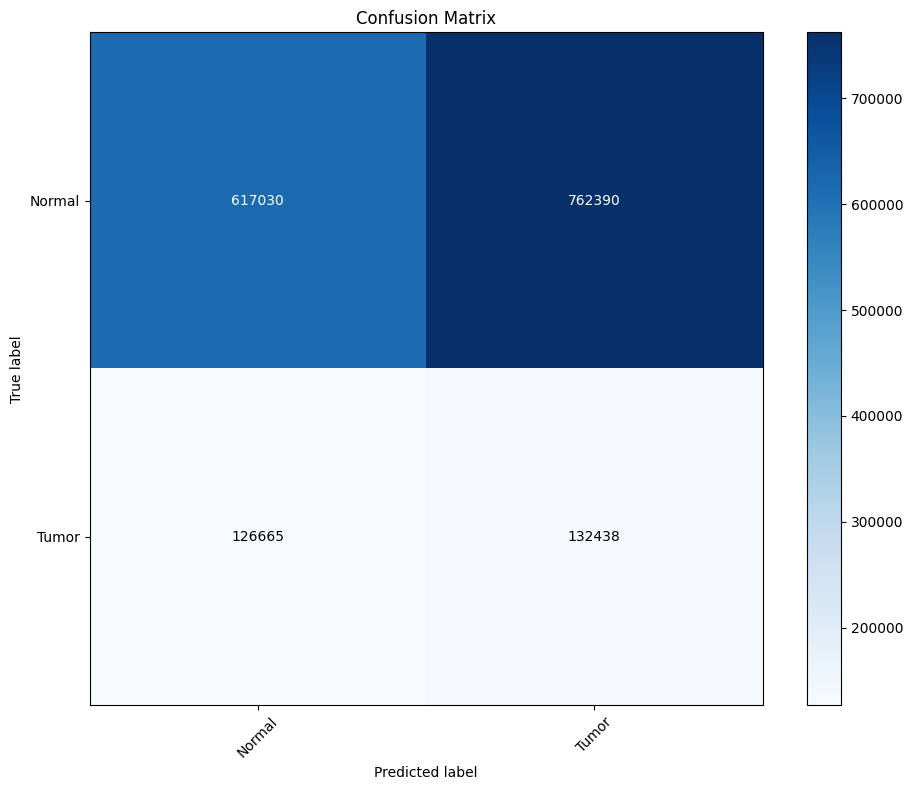

In [8]:
# Load tile predictions
results_dir = "evaluation/10k"  # Update this path
tile_predictions_file = os.path.join(results_dir, "/Users/burhananis/camelyon16-fully-supervised/evaluation/10k/tile_predictions.pkl")

with open(tile_predictions_file, "rb") as f:
    tile_predictions_dict = pickle.load(f)

# Define annotations directory
annotations_dir = "/Users/burhananis/Desktop/camelyon16/annotations/test"  # Update this path

# Evaluate predictions
results = evaluate_patch_predictions(
    tile_predictions_dict, 
    annotations_dir,
    patch_size=256,
    threshold=0.5
)

# Print evaluation metrics
print("\nEvaluation Results:")
print(f"Accuracy: {results['accuracy']:.4f}")
print(f"Precision: {results['precision']:.4f}")
print(f"Sensitivity: {results['sensitivity']:.4f}")
print(f"Specificity: {results['specificity']:.4f}")
print(f"F1 Score: {results['f1_score']:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = results['confusion_matrix']
plot_confusion_matrix(cm)
plt.savefig(os.path.join(results_dir, "confusion_matrix_patch.png"))
plt.show()

# Save results to file
with open(os.path.join(results_dir, "evaluation_results_patch.pkl"), "wb") as f:
    pickle.dump(results, f)

print(f"Results saved to {os.path.join(results_dir, 'evaluation_results_patch.pkl')}")

## Evaluation Results:

Accuracy: 0.9313

Precision: 0.7537

Sensitivity: 0.7947

Specificity: 0.9550

F1 Score: 0.7737